# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

fatal: destination path 'GroceryStoreDataset' already exists and is not an empty directory.


⚡️ Tip	Connect GitHub to Studios: https://lightning.ai/fabiofacchini6-1xn8z/home?settings=integrations



In [ ]:
#!pip install torchsummary
#!pip install calflops

In [ ]:
from pathlib import Path
import numpy as np
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.optim import Adam
from torch.utils.data import random_split, DataLoader, ConcatDataset
from torchvision import transforms as T, datasets
from torchsummary import summary
from calflops import calculate_flops
from torchvision.models import resnet18, ResNet18_Weights

In [21]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

# Introduction
In this first part of the project, we have developed a network that borrows different concepts from the networks that have marked their sign in the computer vision history. Our goal was to construct a model that reaches the requested accuracy with a reasonable number of parameters and the lowest possible training time and number of Flops. The main structure is taken from VGG, with insertions from other networks like stem layers and batch normalization that we judged as valuable for our objective.

#### Fix the seed to avoid randomicity

In [22]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Dataset manipulation and data augmentation


The provided dataset has some variability in the source images, so the first step has been to apply some transformations to make data uniform:
- all the images have been resized to the most recurrent ones `(348x348)`, as we can see from the bar plot below; 
- then, a normalization step has been applied using `compute_mean_std()` to compute the mean and standard deviation.

The dataset have also been augmented in order to enhance the model performances. The augmentation consists of:
- a **random crop** of the images of dimensions at least equal to the 80% of the original ones
- a **random horizontal flip**
- a **random rotation** of 10 degrees.

In [23]:
def exploration(data, title):
    s = {}
    for img in data:
        key = f'{img[0].size[0]}x{img[0].size[1]}'
        if key in s:
            s[key] += 1
        else:
            s[key] = 1
    plt.bar(list(s.keys()), list(s.values()))
    plt.title(title)
    plt.show()

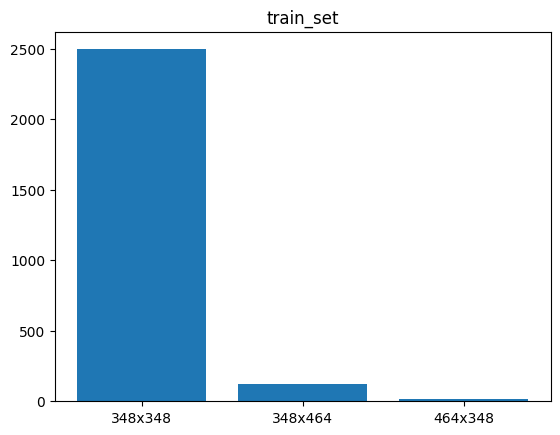

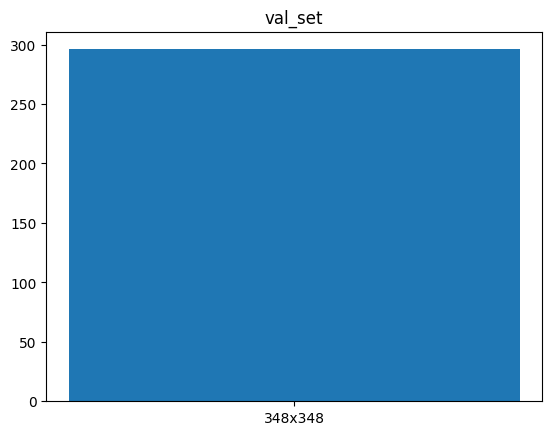

In [ ]:
exploration(GroceryStoreDataset(split="train"), 'train_set')
exploration(GroceryStoreDataset(split="val"), 'val_set')
#exploration(GroceryStoreDataset(split="test"), 'test_set')

In [25]:
def compute_mean_std(dataset):
    mean = 0.0
    std = 0.0
    total_images = 0

    for images, _ in dataset:
        batch_samples = images.size(0)
        total_images += batch_samples
        mean += images.mean([0, 2, 3]) * batch_samples
        std += images.std([0, 2, 3]) * batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

In [26]:
image_size = (348, 348)
batch_size = 64
batch_size_large = 128

base_transformations = T.Compose([T.Resize(image_size), T.ToTensor()])

dset_train = GroceryStoreDataset(split="train", transform=base_transformations)
num_classes = dset_train.get_num_classes()
dset_train = DataLoader(dset_train, batch_size=batch_size, shuffle=True)

dset_val = GroceryStoreDataset(split="val", transform=base_transformations)
dset_val = DataLoader(dset_val, batch_size=batch_size, shuffle=False)

#data_test = GroceryStoreDataset(split="test", transform=base_transformations)
#dset_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

mean_tr_dset, std_tr_dset = compute_mean_std(dset_train)
mean_val_dset, std_val_dset = compute_mean_std(dset_val)

All the transformations previously mentioned are contained in the dictionary below, **data_transformations**.

In [27]:
data_transforms = {
    "train_aug": T.Compose([T.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
                        T.RandomHorizontalFlip(),
                        T.RandomRotation(10),
                        T.ToTensor(),
                        T.Normalize(mean_tr_dset, std_tr_dset), 
                        T.CenterCrop(image_size)]),
    
    "train": T.Compose([T.Resize(image_size),
                      T.ToTensor(),
                      T.Normalize(mean_tr_dset, std_tr_dset)]),

    "val": T.Compose([T.Resize(image_size),
                      T.ToTensor(),
                      T.Normalize(mean_val_dset, std_val_dset)])
}

To speed up the model comparisons, all the datasets and dataloaders have been instantiated here:
- **train_dl** is the standard dataset, with batch size 64
- **train_dl_aug_64** is the augmented dataset, with batch size 64
- **train_dl_aug_128** is the augmented dataset, with batch size 128

In [28]:
data_train = GroceryStoreDataset(split="train", transform=data_transforms["train"])
train_dl = DataLoader(data_train, batch_size=batch_size, shuffle=True)

data_val = GroceryStoreDataset(split="val", transform=data_transforms["val"])
val_dl = DataLoader(data_val, batch_size=batch_size, shuffle=False)

datasets_aug = [GroceryStoreDataset(split="train", transform=data_transforms["train"]), GroceryStoreDataset(split="train", transform=data_transforms["train_aug"])]
data_train_aug = ConcatDataset(datasets_aug)
train_dl_aug_64 = DataLoader(data_train_aug, batch_size=batch_size, shuffle=True)
train_dl_aug_128 = DataLoader(data_train_aug, batch_size=batch_size_large, shuffle=True)

#### Train loop

In [ ]:
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model, train_dl, epochs, opt, sched=None, val_dl=None, verbose=False, patience= 15):
    best_val_acc = 0
    best_params = []
    best_epoch = -1
    tr_acc_list = []
    val_acc_list = []
    tr_loss_list = []
    val_loss_list = []
    early_stopping_counter = 0

    for e in range(epochs):

        model.train() 
        early_stopping_counter += 1

        # Training metrics
        train_loss = 0
        train_samples = 0
        train_acc = 0
        curr_lr = opt.param_groups[-1]['lr']

        for idx, train_data in enumerate(train_dl):
        
            imgs = train_data[0].to(device)
            labels = train_data[1].to(device)
            scores = model(imgs)

            loss = F.cross_entropy(scores, labels)
            train_loss += loss.item() * imgs.shape[0]
            train_samples += imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()
            
            opt.zero_grad()
            loss.backward()
            opt.step()

        train_acc /= train_samples
        train_loss /= train_samples

        # Validation step
        model.eval()
        
        with torch.no_grad():
            val_loss = 0
            val_samples = 0
            val_acc = 0

            if val_dl is not None:
                for val_data in val_dl:
                    imgs = val_data[0].to(device)
                    labels = val_data[1].to(device)
                    val_scores = model(imgs)
                    val_loss += F.cross_entropy(val_scores, labels).item() * imgs.shape[0]
                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()

                val_acc /= val_samples
                val_loss /= val_samples
            
            if sched is not None:
                sched.step(val_acc)

            if val_dl is None or val_acc > best_val_acc:
                best_train_acc = train_acc
                best_val_acc = val_acc if val_dl is not None else 0
                best_val_loss = val_loss if val_loss is not None else 0
                best_params = model.state_dict()
                best_epoch = e
                early_stopping_counter = 0
            
            if early_stopping_counter > patience:
                break

            if verbose:
                print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" +
                      ("" if val_dl is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}"))

        tr_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        tr_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
            
    # Final report of the best epoch and accuracy
    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc:.3f}")

    return best_train_acc, best_val_acc, best_val_loss, tr_acc_list, val_acc_list, tr_loss_list, val_loss_list

# Model

The complete model structure, as it is also visible from the summary, consists of the following layers:
- a **stem layer** composed by:
    - **convolution** layer with kernel_size=7, stride=2 and padding=3
    - **batch normalization** layer
    - **ReLu** as activation
    - **max pooling** layer
- **4 stages** with 2 convolutions each, starting with 32 activation channels:
    - each convolution has kernel size=3, with stride=1 and padding=1
    - each convolution is followed by a *Batch Normalization* layer and *ReLu* as activation function
- **global average pooling**
- **dropout**, set to 0.3
- **fully connected** layer as final classifier.

The base structure of the model is inspired by VGG trying to enhance its performances with the later years' improvements, explained in detail in the Ablation Study section.

The choice of the hyperparameters is the following:
- `torch.optim.Adam` as optimizer, with *learning_rate 0.001* and *weight decay 0.01*
- `torch.optim.lr_scheduler.ReduceLROnPlateau` with *patience 5* and *decreasing factor 0.2*, providing an adaptive learning rate in proximity of the convergence.

In [30]:
class Stage(nn.Module):
    def __init__(self, in_ch:int, out_ch:int, activation:nn.Module, block_number:int, batch_norm:nn.Module(), stride:int=2):
        super(Stage, self).__init__()
        self.activation = activation
        self.block_number = block_number
            
        self.block1 = nn.Sequential(
                        nn.Conv2d(in_ch, out_ch, kernel_size = 3, stride = stride, padding = 1),
                        batch_norm(out_ch),
                        self.activation())
        self.block2 = nn.Sequential(
                        nn.Conv2d(out_ch, out_ch, kernel_size = 3, stride = 1, padding = 1),
                        batch_norm(out_ch),
                        self.activation())
    
    def forward(self, x):
        out = self.block1(x)
        for i in range(self.block_number - 1):
            out_2 = self.block2(out)
        return out

In [31]:
class GroceryStoreModule(nn.Module):
    def __init__(self, blocks_number:list=[2, 2, 2, 2], image_channels:int=3, base_channels:int=32, num_classes:int=43, activation:nn.Module=nn.ReLU, use_stem:bool=True, use_bn:bool=True, use_dropout:bool=True):
        super(GroceryStoreModule, self).__init__()
        self.use_dropout = use_dropout
        self.base_channels = base_channels
        
        self.dropout = nn.Dropout(0.3)
        if use_bn:
            self.batch_norm = nn.BatchNorm2d
        else:
            self.batch_norm = nn.Identity
        if use_stem:
            self.stem_layers = nn.Sequential(
                                nn.Conv2d(image_channels, self.base_channels, kernel_size=7, stride=2, padding=3),
                                self.batch_norm(self.base_channels),
                                activation(),
                                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                )
            self.inchannels = self.base_channels
        else:
            self.stem_layers = nn.Sequential()
            self.inchannels = image_channels
        
        stages = []
        stages.append(Stage(self.inchannels, self.base_channels, activation, blocks_number[0], self.batch_norm, stride=1))
        for i in range(1, len(blocks_number)):
            stages.append(Stage(self.base_channels*(2**(i-1)), self.base_channels*(2**(i)), activation, blocks_number[i], self.batch_norm))
        self.stages = nn.Sequential(*stages)
        self.final_classifier = nn.Linear(self.base_channels*(2**(len(blocks_number)-1)), num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def clear_weights(self):
        for layer in self.modules():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    def forward(self, x):
        out = self.stem_layers(x)
        out = self.stages(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        if self.use_dropout:
            out = self.dropout(out)
        out = self.final_classifier(out)
        return out

#### Summary of the full model

In [32]:
full_cfg = {
    'model': GroceryStoreModule([2, 2, 2, 2], base_channels=32, activation=nn.ReLU, use_bn=True, use_stem=True, use_dropout=True),
    'lr': 0.001,
    'dataset': train_dl_aug_64
}
full_model = full_cfg['model'].to(device)
summary(full_model, (3 , 348, 348), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 174, 174]           4,736
       BatchNorm2d-2         [-1, 32, 174, 174]              64
              ReLU-3         [-1, 32, 174, 174]               0
         MaxPool2d-4           [-1, 32, 87, 87]               0
            Conv2d-5           [-1, 32, 87, 87]           9,248
       BatchNorm2d-6           [-1, 32, 87, 87]              64
              ReLU-7           [-1, 32, 87, 87]               0
            Conv2d-8           [-1, 32, 87, 87]           9,248
       BatchNorm2d-9           [-1, 32, 87, 87]              64
             ReLU-10           [-1, 32, 87, 87]               0
            Stage-11           [-1, 32, 87, 87]               0
           Conv2d-12           [-1, 64, 44, 44]          18,496
      BatchNorm2d-13           [-1, 64, 44, 44]             128
             ReLU-14           [-1, 64,

# Ablation Study

All the tests of the ablation study are done on the basis of the dictionary **ablation_cfg**, which contains the configuration of each single model, with its own hyperparameters.

In [33]:
def update_dict(key, value, dict= full_cfg):
    upd_cfg = dict.copy()
    upd_cfg[key] = value
    return upd_cfg

In [34]:
ablation_cfg = {
    'full_model' : full_cfg,
    'no_batch_norm' : update_dict('model', GroceryStoreModule(use_bn=False)),
    'no_stem_layers': update_dict('model', GroceryStoreModule(use_stem=False)),
    'no_dropout': update_dict('model', GroceryStoreModule(use_dropout=False)),
    'smaller_network': update_dict('model', GroceryStoreModule([2, 2, 2])),
    'wider_network': update_dict('model', GroceryStoreModule([2, 2, 2], base_channels=64)),
    'no_data_augmentation': update_dict('dataset', train_dl),
    'higher_LR': update_dict('lr', 0.01),
    'larger_batch_size': update_dict('dataset', train_dl_aug_128)
}

In [35]:
def execute(cfgs, n_exec, epochs= 60):
    results = pd.DataFrame(columns=['model', 'params', 'flops', 'best_val_accuracy', 'best_train_accuracy'])
    plots = {}

    for model_name, cfg in zip(cfgs.keys(), cfgs.values()):

        train_accs = []
        val_accs = []
        val_losses = []
        
        for num in range(n_exec):
            ### Model ###
            model = cfg['model']
            model.clear_weights()
            model.to(device)
            
            ### Optimizer ###
            optimizer = torch.optim.Adam(model.parameters(), lr=cfg['lr'], weight_decay = 0.01)
            
            ### Scheduler ###
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.2, patience=5)
            
            ### Data Augmentation ###
            train_data = cfg['dataset']
                
            ### Training ###
            best_train_acc, best_val_acc, best_val_loss, train_accuracy, val_accuracy, train_loss, val_loss = train_loop(
                model,
                train_data,
                epochs,
                optimizer,
                scheduler,
                val_dl,
                verbose=False)
            
            ### Partial Results ###
            train_accs.append(best_train_acc)
            val_accs.append(best_val_acc)
            val_losses.append(best_val_loss)

            if model_name in plots:
                plots[model_name]['train_acc'].append(train_accuracy)
                plots[model_name]['train_loss'].append(train_loss)
                plots[model_name]['val_acc'].append(val_accuracy)
                plots[model_name]['val_loss'].append(val_loss)
            else:
                plots[model_name] = {'train_acc' : [train_accuracy],
                                'train_loss' : [train_loss],
                                'val_acc' : [val_accuracy],
                                'val_loss' : [val_loss]}

            torch.cuda.empty_cache()

                
        if model_name == 'larger_batch_size':
            input_shape=(128, 3, 348, 348)
        else:
            input_shape=(64, 3, 348, 348)
            
        flops, mac, params = calculate_flops(ablation_cfg[model_name]['model'], input_shape= input_shape, output_as_string=True, output_precision=4, print_detailed=False, print_results= False)
        ### Final Results ###
        results.loc[len(results)] = [model_name
                                    ,params
                                    ,flops
                                    ,np.mean(val_accs)
                                    ,np.mean(train_accs)]

    return results, plots

In [36]:
results, plots = execute(ablation_cfg, 1, epochs= 80)

The guideline for this ablation is based on demonstrating how the network behaves on the task and highlighting the importance of each component. Hence, the study present how erasing them one at a time affects the general performances.  

The experiments are trained for *80 epochs* with an **early stopping** on the validation accuracy of *patience* equal to 15. As shown in the table and the plots below, the results underline the following aspects and considerations:

- the **full model** reaches 0.685 accuracy on the validation split with the lowest Flops consumption.
- the model **without batch normalization** is not even able to reach the required validation accuracy. This results is not a surprise and highlights the fact that this layer plays a crucial role, since the training accuracy itself remains very low, such that the model does not fit the data enough.
- removing **stem layers** not only affects the accuracy on the validation, but most of all lets the Flops consumption grow to more than 10 times the base model one.
- the abscence of the **dropout** seems to increase the performances. Anyway, it has been decided to keep it, since this result could depend on having a small dataset compared to a real one and, since dropout should increase generalization, keeping it could increase the performances when dealing with new unseen data. 
- maintaing the same structure, the network can be tweaked by changing the *depth* or the *width*. A **smaller network** gets a worse outcome, due to a much lower number of parameters. A **wider network** with 3 stages instead of 4, constructed to have the same number of parameters with 2 times the number of channels in each stage, gets similar results with respect to the base model. However, the Flops comsumption is 4 times larger, resulting in a less efficient network.
- **data augmentation** and a much **higher learning rate** heavily affects the performances of the network, as we could expect.
- a **larger batch size** slightly worsen the performances in terms of validation accuracy. Futhermore, the flops consumption grows, so it has been decided to keep the smaller one.

In [40]:
results

,model,params,flops,best_val_accuracy,best_train_accuracy
0,full_model,1.1984 M,77.7439 GFLOPS,0.685811,0.947348
1,no_batch_norm,1.1964 M,77.5023 GFLOPS,0.496622,0.634848
2,no_stem_layers,1.1852 M,807.837 GFLOPS,0.581081,0.791098
3,no_dropout,1.1984 M,77.7439 GFLOPS,0.702703,0.969697
4,smaller_network,306.603 K,64.0265 GFLOPS,0.587838,0.783333
5,wider_network,1.203 M,218.579 GFLOPS,0.679054,0.893561
6,no_data_augmentation,1.1984 M,77.7439 GFLOPS,0.621622,0.926515
7,higher_LR,1.1984 M,77.7439 GFLOPS,0.462838,0.603598
8,larger_batch_size,1.1984 M,155.488 GFLOPS,0.655405,0.918182


In [38]:
def plot_results(results):
    plt.figure(figsize=(18, 8))
    plt.title('validation accuracy')
    
    for key in results:
        to_plot = np.mean(np.array(results[key]['val_acc']), axis= 0)
        plt.plot(range(1, len(to_plot)+1), to_plot, marker='.', label= key)
    plt.legend()
    plt.show()

    plt.figure(figsize=(18, 8))
    plt.title('validation loss')
    
    for key in results:
        to_plot = np.mean(np.array(results[key]['val_loss']), axis= 0)
        plt.plot(range(1, len(to_plot)+1), to_plot, marker='.', label= key)

    plt.legend()
    plt.show()
    plt.figure(figsize=(18, 8))
    plt.title('training accuracy')
    
    for key in results:
        to_plot = np.mean(np.array(results[key]['train_acc']), axis= 0)
        plt.plot(range(1, len(to_plot)+1), to_plot, marker='.', label= key)
    plt.legend()
    plt.show()
    plt.figure(figsize=(18, 8))
    plt.title('training loss')
    
    for key in results:
        to_plot = np.mean(np.array(results[key]['train_loss']), axis= 0)
        plt.plot(range(1, len(to_plot)+1), to_plot, marker='.', label= key)
    plt.legend()
    plt.show()

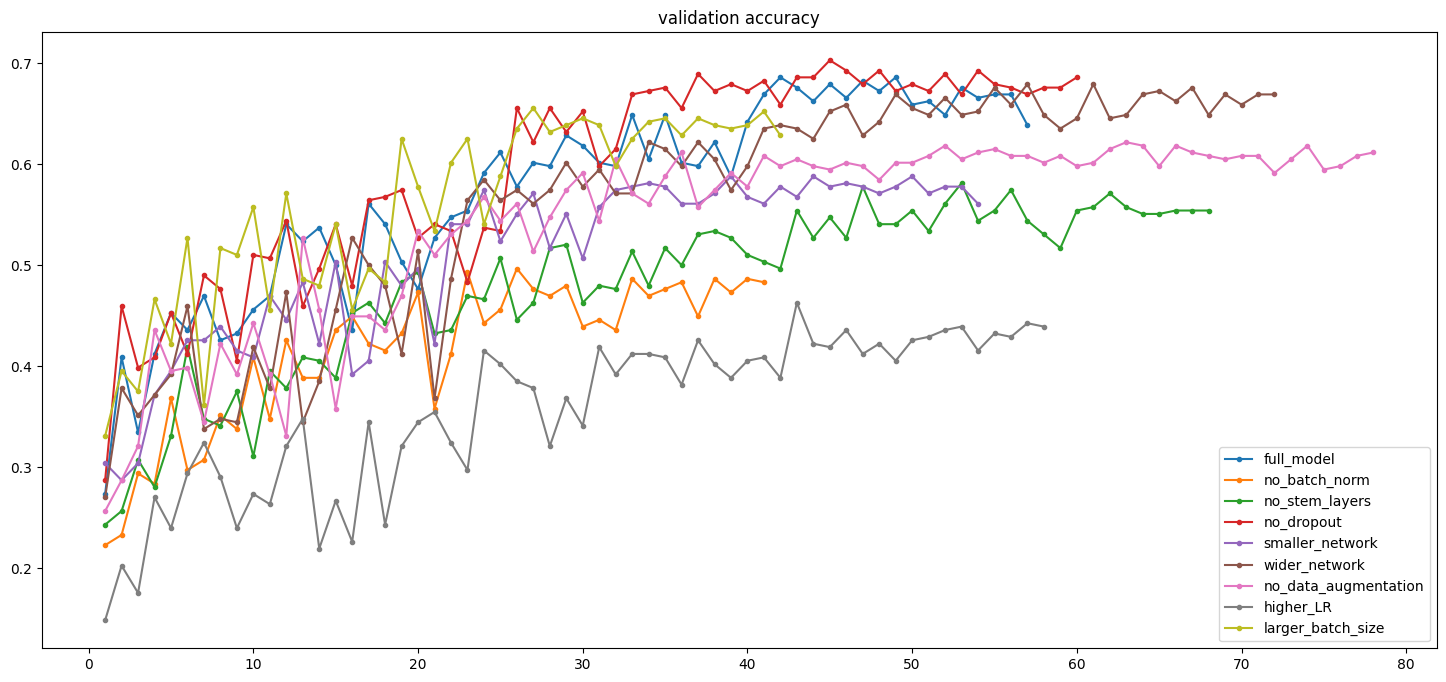

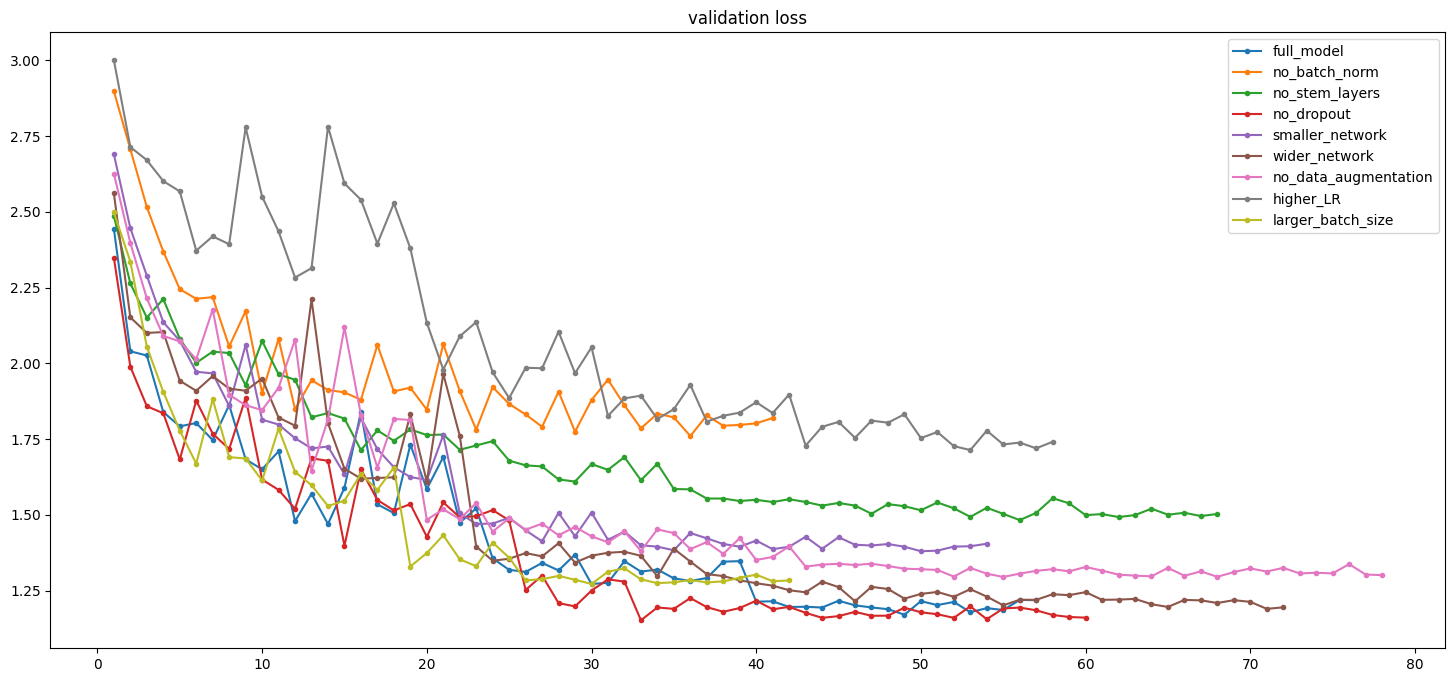

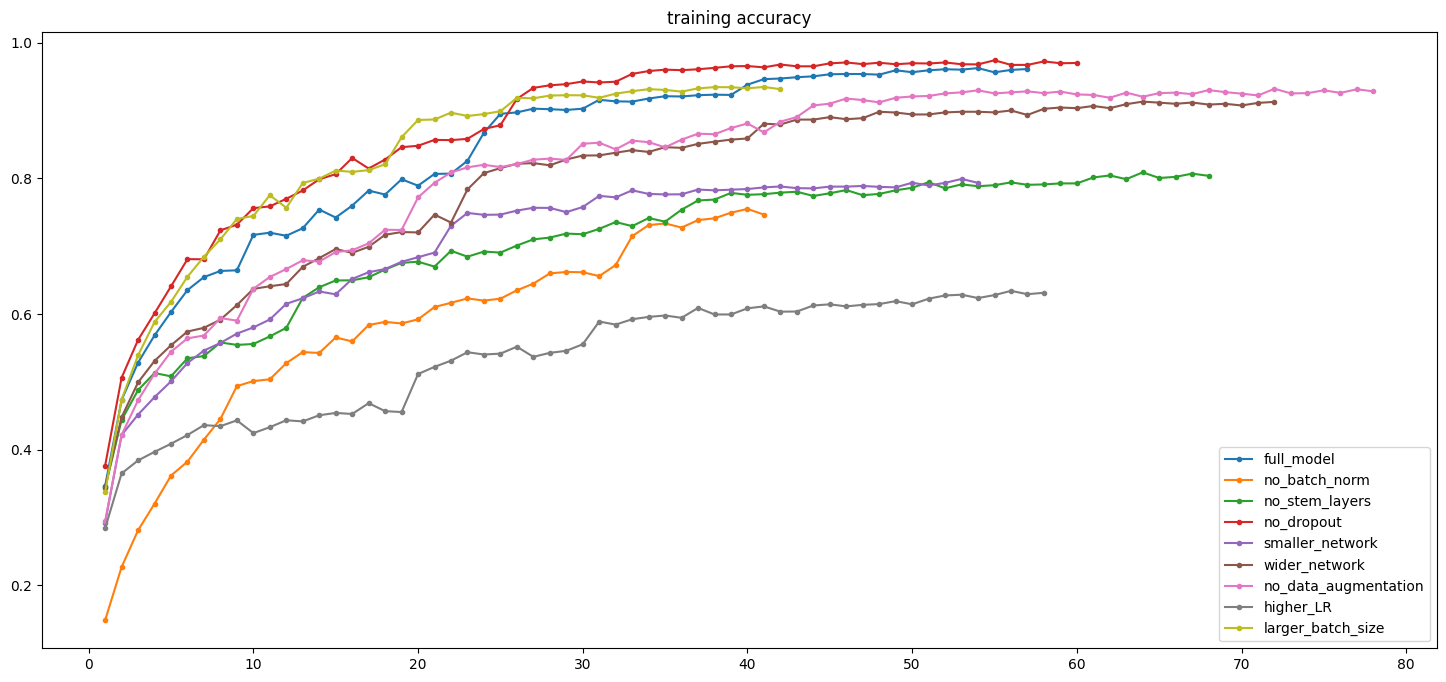

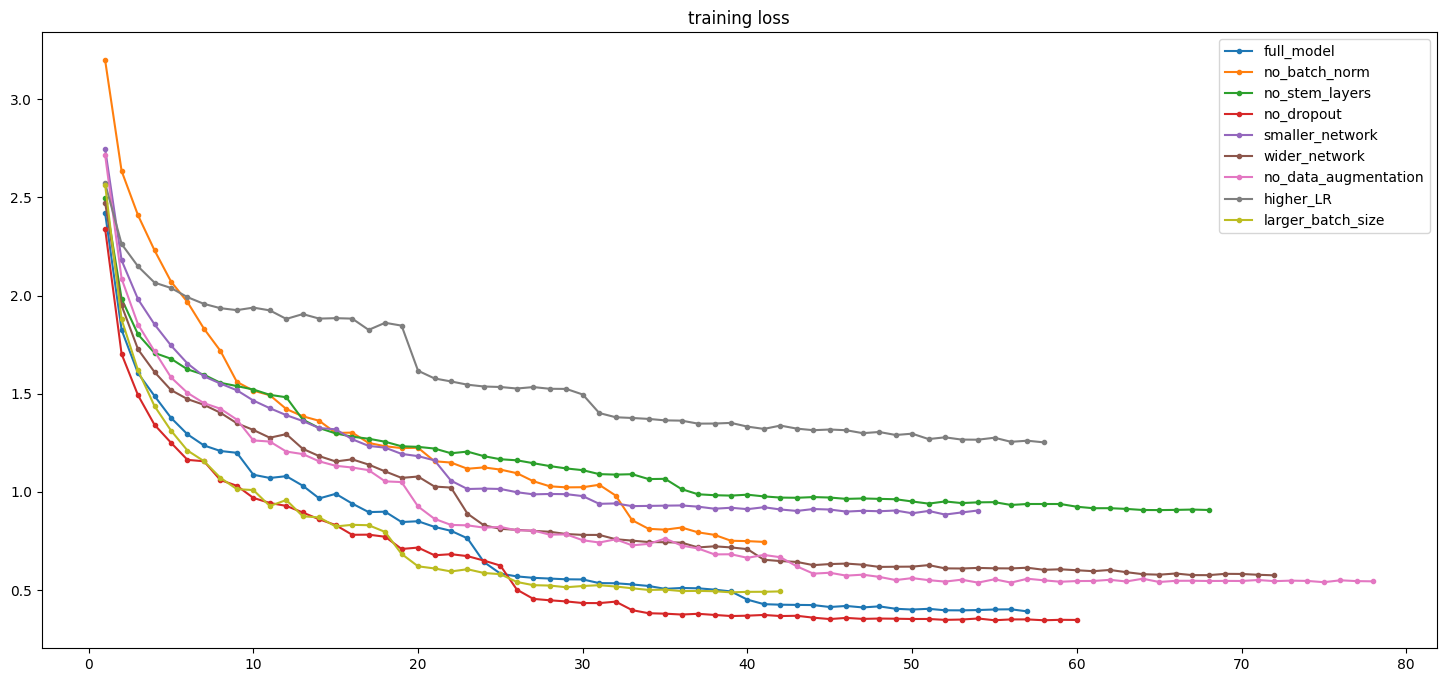

In [39]:
plot_results(plots)

---

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

### Fine-tuning ResNet-18

For this section, we proceed through the same guideline for both fine-tuning procedures on the **ResNet-18** model, followed by a `nn.Linear` layer to adapt the final classifier to our dataset. In particular, we split each training loop into two steps:
- a **Transfer Learning** step for just a few epochs to initialize the weights of the classifier;
- a second step in which we **fine-tune** all the weights of the network for the remaining epochs.

In [ ]:
class ResNetModule(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def transferLearning(self):
        for p in self.model.parameters():
            p.requires_grad = False
        for p in self.model.fc.parameters():
            p.requires_grad = True

    def unfreeze_all(self):
        for p in self.model.parameters():
            p.requires_grad = True
    
    def forward(self, x):
        return self.model(x)

In [67]:
def fine_tuning(model, opt, sched, tl_epochs, ft_epochs):
    
    model.transferLearning()
    train_loop(
        model,
        train_dl_aug_64,
        tl_epochs,
        opt,
        sched,
        val_dl,
        verbose=False
    )

    model.unfreeze_all()
    _, best_val_acc, best_val_loss, train_accuracy, val_accuracy, train_loss, val_loss = train_loop(
        model,
        train_dl_aug_64,
        ft_epochs,
        opt,
        sched,
        val_dl,
        verbose=False
    )
    
    return best_val_acc, best_val_loss, train_accuracy, val_accuracy, train_loss, val_loss

In [68]:
results_resnet = pd.DataFrame(columns=['validation accuracy', 'validation loss'])
plots_resnet = {}

#### Fine-tuning with the previous hyperparameters

In [69]:
resnet = ResNetModule(43).to(device)
opt_myhp = torch.optim.Adam(resnet.parameters(), lr=0.001, weight_decay = 0.01)
sched_myhp = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_myhp, 'max', patience=5, factor= 0.2)
epochs_myhp = 80

best_val_acc, best_val_loss, train_acc, val_acc, train_loss, val_loss = fine_tuning(
    resnet, 
    opt_myhp, 
    sched_myhp, 
    epochs_myhp//5, 
    epochs_myhp*4//5
)
### FN = full network ###
results_resnet.loc['base_hyperparams'] = [best_val_acc, best_val_loss]
plots_resnet['base_hyperparams'] = {'train_acc' : [train_acc],
                            'train_loss' : [train_loss],
                            'val_acc' : [val_acc],
                            'val_loss' : [val_loss]}

#### Fine-tuning with the optimal hyperparameters
The choice of the optimal hyperparameters is based on the paper [*"Rethinking the hyperparameters for fine-tuning."*](https://arxiv.org/abs/2002.11770), from which we have taken the basic principles that authors have underlined. The paper is about finding optimal ways to fine-tune ResNet-101, providing useful insights for different types of tasks on various datasets. We focused mostly on the outcomes for classification tasks regarding the *ELR (Effective Learning Rate)* and the *effective weight decay* to adapt the hyperparameters to our specific dataset and get the best possible score.

In [70]:
resnet = ResNetModule(43).to(device)
opt_besthp = torch.optim.SGD(resnet.parameters(), lr=0.01, weight_decay=0.005, momentum=0.9, nesterov=True)
sched_besthp = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_besthp, 'max', patience=5, factor= 0.2)
epochs_besthp = 30

best_val_acc, best_val_loss, train_acc, val_acc, train_loss, val_loss = fine_tuning(
    resnet, 
    opt_besthp, 
    sched_besthp, 
    epochs_besthp//2, 
    epochs_besthp//2
)

results_resnet.loc['tweak_hyperparams'] = [best_val_acc, best_val_loss]
plots_resnet['tweak_hyperparams'] = {'train_acc' : [train_acc],
                            'train_loss' : [train_loss],
                            'val_acc' : [val_acc],
                            'val_loss' : [val_loss]}

# Results

In [71]:
results_resnet

,validation accuracy,validation loss
base_hyperparams,0.847973,0.625091
tweak_hyperparams,0.915541,0.308289


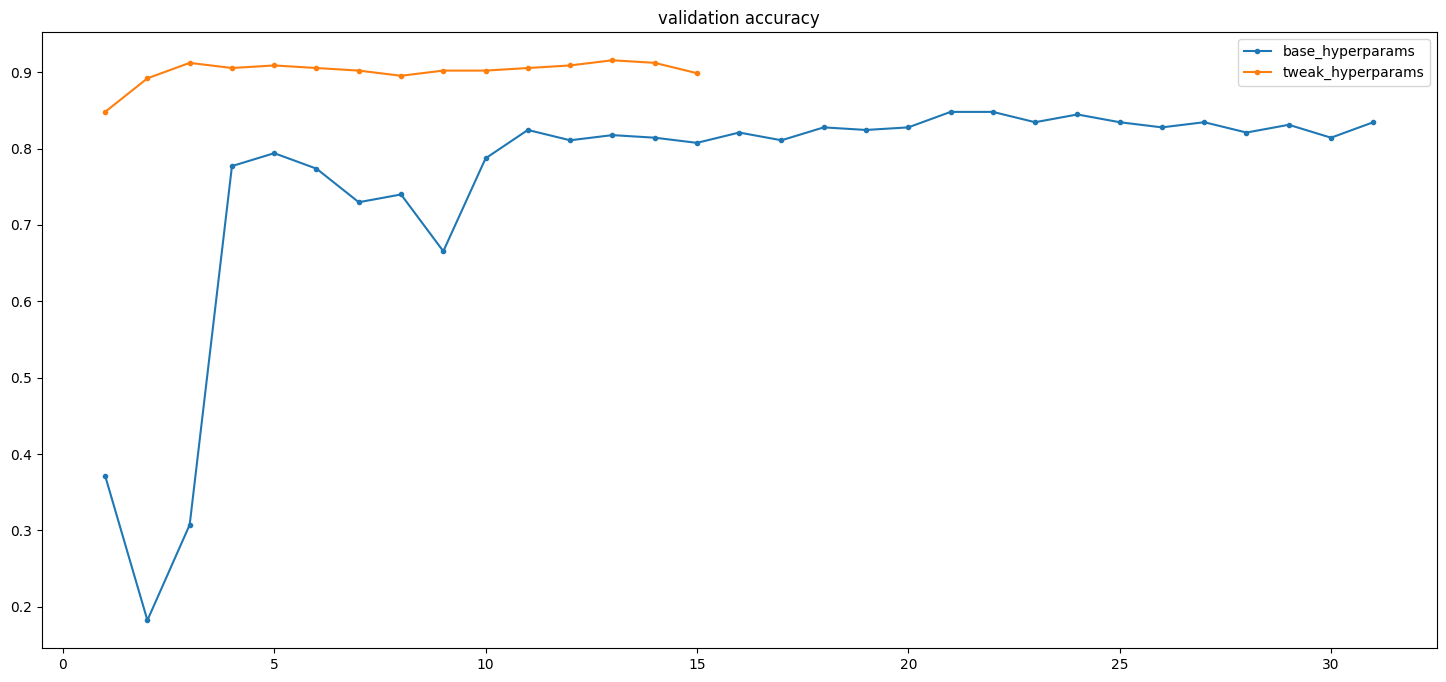

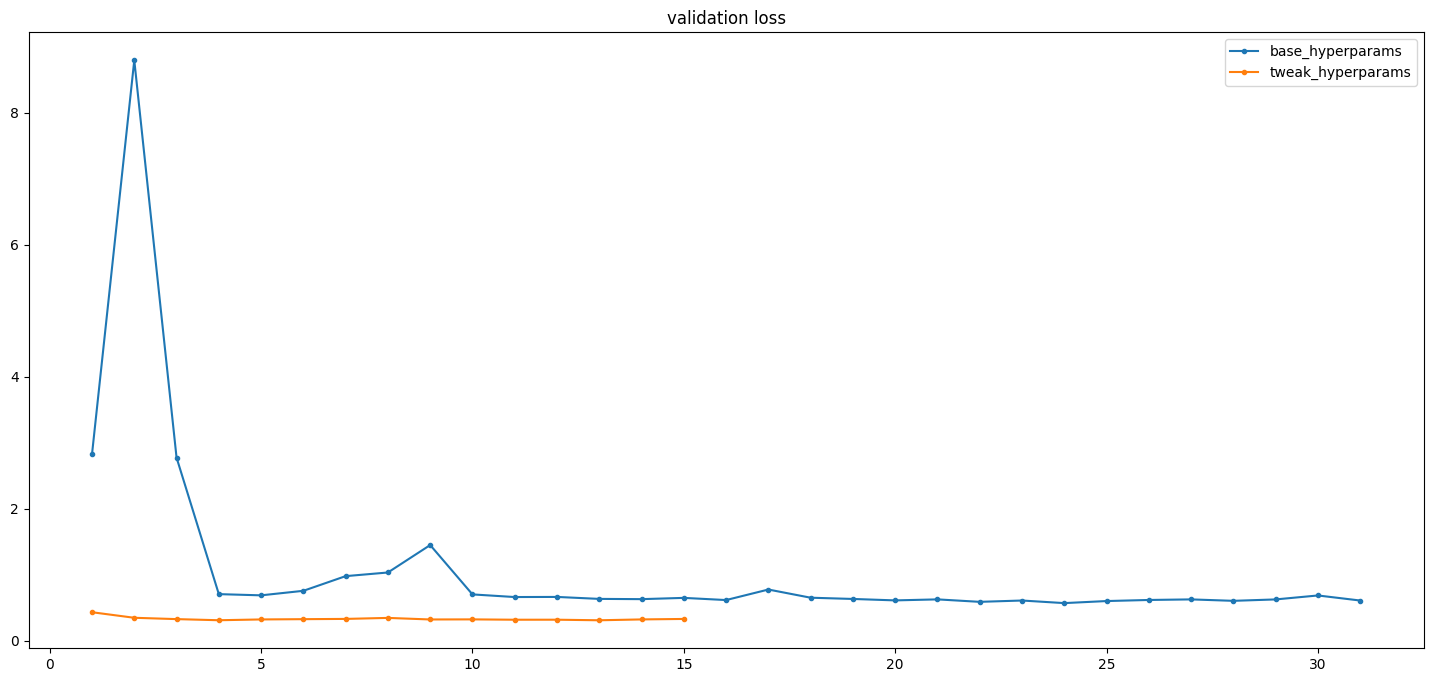

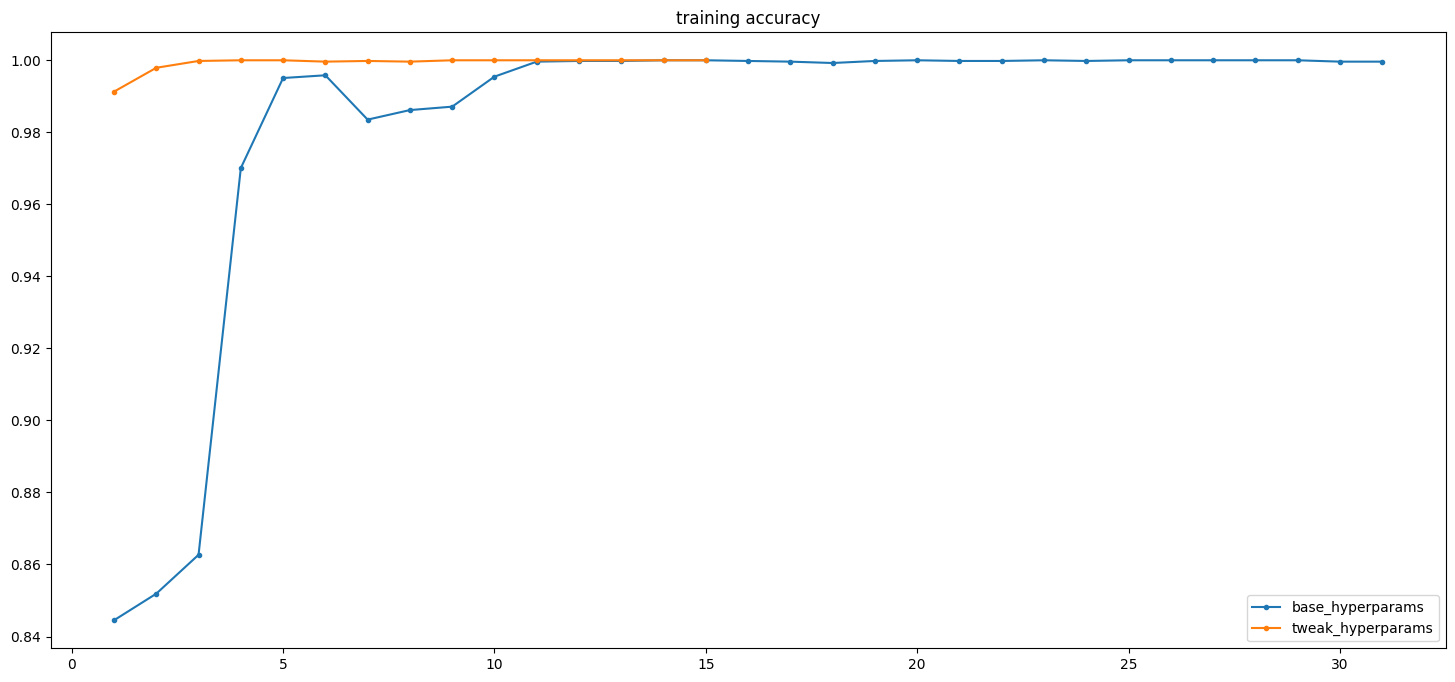

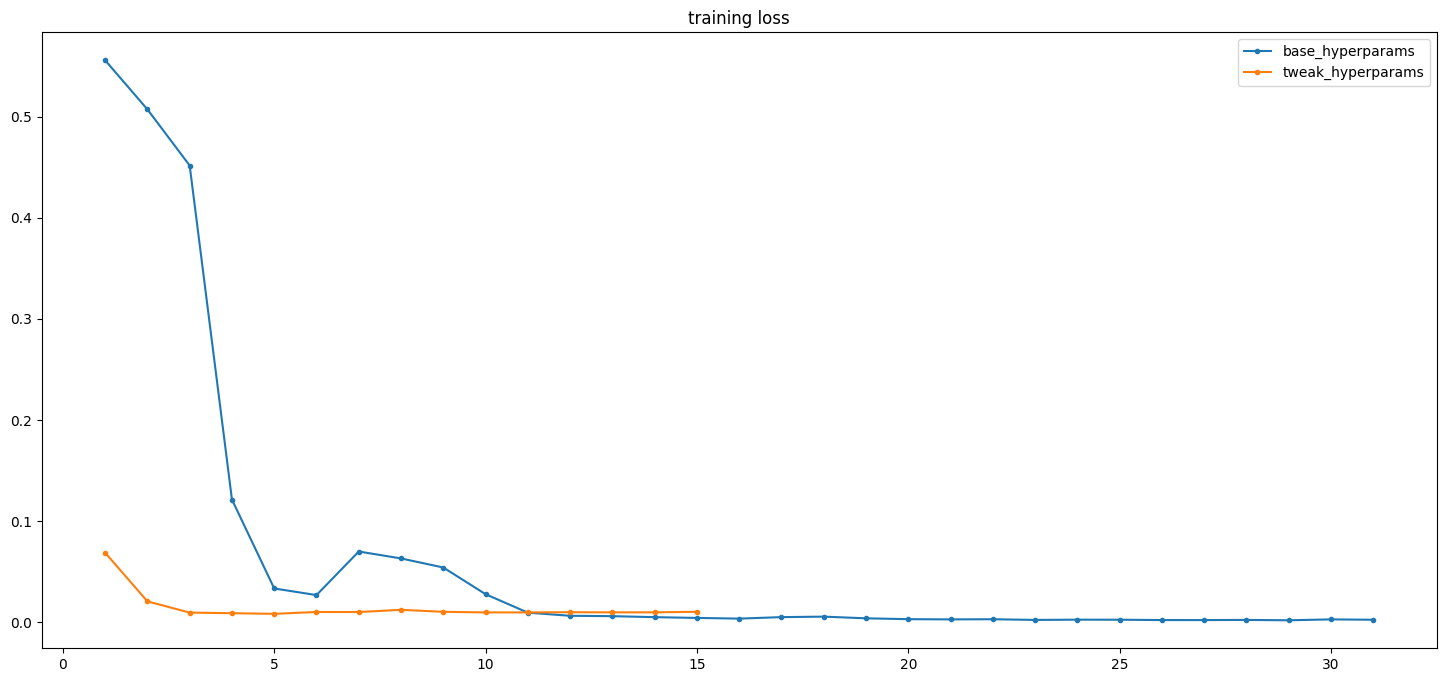

In [72]:
plot_results(plots_resnet)

# Conclusions
These results show that the choice of the hyperparameters is crucial to adapt a model to a specific datatset that differs from the one it is trained on. First of all, from the analysis of the outcomes of the tuning without any specific hyperparameter, we have decided to **reduce the epochs number**, since the training loss lowers very quickly. In addition, for this task, the choice of the **SGD optimizer**, as suggested by the paper, allows to have a better control of the training flow, getting a better convergence. In the paper, it is also said to reduce the learning rate gradually with the increasing epochs number, so we decided to keep the same scheduler from part 1, but with slightly different hyperparameters. These decisions permitted us to get a big improvement in the results, with a score of 0.9xx.

# References:
- [Li, Hao, et al. *"Rethinking the hyperparameters for fine-tuning."* arXiv preprint arXiv:2002.11770 (2020).](https://arxiv.org/abs/2002.11770)